In [59]:
import pandas as pd
import numpy as np

df_dev = pd.read_csv('data/development.csv').set_index('Id')
df_eval = pd.read_csv('data/evaluation.csv').set_index('Id')

# We drop the sampling rate, which is the same value for all samples
# We drop the path, which is not useful for the regression task
df_dev.drop(['sampling_rate', 'path'], axis=1, inplace=True)
df_eval.drop(['sampling_rate', 'path'], axis=1, inplace=True)

# We convert the tempo to the float data type from the format '[float]'
df_dev['tempo'] = df_dev['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')
df_eval['tempo'] = df_eval['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')

df_dev.head()

,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905


Plot age distribution

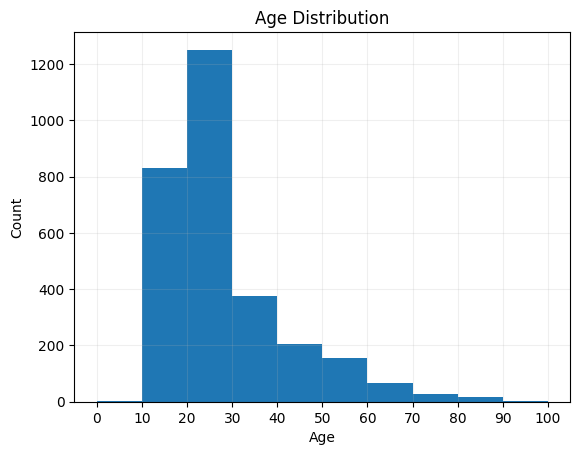

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(df_dev["age"], bins=range(0,int((max(df_dev["age"])+10)),10))
ax.set_xticks(range(0,int((max(df_dev["age"])+10)),10))
ax.set_title("Age Distribution")
ax.set_xlabel("Age")
ax.set_ylabel("Count")
ax.grid(alpha=0.2)

Ethnicity distribution

In [61]:
# Ethnicities in development set
set1 = set(df_dev["ethnicity"])
set2 = set(df_eval["ethnicity"])
set1.intersection(set2)
print(f"Number of ethnicities in development set: {len(set1)}")
print(f"Number of ethnicities in evaluation set: {len(set2)}")
print(f"Number of ethnicities in both sets: {len(set1.intersection(set2))}")
print(set1.intersection(set2))

Number of ethnicities in development set: 165
Number of ethnicities in evaluation set: 73
Number of ethnicities in both sets: 17
{'igbo', 'igala', 'yoruba', 'ikwerre', 'annang', 'indian', 'ibibio', 'urhobo', 'congolese', 'afemai', 'satawalese', 'ijaw', 'cameroonian', 'hausa', 'ukwani', 'kanuri', 'nigerian'}


In [62]:
df_dev.drop(columns=['ethnicity'], inplace=True)
df_eval.drop(columns=['ethnicity'], inplace=True)

Gender

In [63]:
gender =  {'male': 1, 'female': 0, "famale": 0}

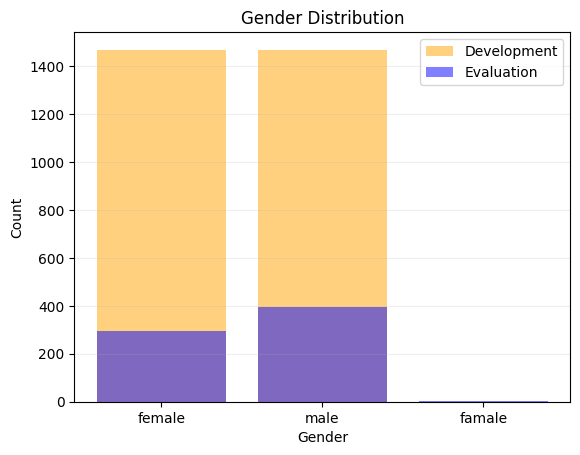

In [64]:
from collections import Counter

gender_dev = Counter(df_dev["gender"])
gender_eval = Counter(df_eval["gender"])
plt.figure()
plt.bar(gender_dev.keys(), gender_dev.values(), label="Development", color="orange", alpha=0.5)
plt.bar(gender_eval.keys(), gender_eval.values(), label="Evaluation", color="blue", alpha=0.5)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.2, axis="y")

In [65]:
# We encode the gender using dummy encoding
df_dev['gender'] = df_dev['gender'].map(gender)
df_eval['gender'] = df_eval['gender'].map(gender)

In [66]:
import os
import librosa

mfcc_num = 13
ll = []
sampling_rates_dev = []
sampling_rates_eval = []
for f in os.listdir("data/audios_development"):
    try:
        # get natural embedded sampling rate of each audio
        y, sr = librosa.load(f"data/audios_development/{f}", sr=None)
        sampling_rates_dev.append(sr)
        index = int(f.split(".")[0]) - 1
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        duration = librosa.get_duration(y=y, sr=sr, n_fft=512)
        mfdd = librosa.feature.delta(mfcc)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=512).mean(axis=1)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=512).mean(axis=1)

        d = {f"MFCC-{el+1}-95": np.percentile(mfcc, 95, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCC-{el+1}-5": np.percentile(mfcc, 5, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCC-{el+1}-50": np.percentile(mfcc, 50, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCCD-{el+1}-95": np.percentile(mfdd, 95, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCCD-{el+1}-5": np.percentile(mfdd, 5, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCCD-{el+1}-50": np.percentile(mfdd, 50, axis=1)[el] for el in range(mfcc_num)}
        ll.append({'Id': index, "duration": duration, "spectral_bandwidth": spectral_bandwidth, "spectral_rolloff": spectral_rolloff, **d})
    except:
        pass
df1 = pd.DataFrame(ll).set_index('Id').sort_index()

ll = []
for f in os.listdir("data/audios_evaluation"):
    try:
        y, sr = librosa.load(f"data/audios_evaluation/{f}", sr=None)
        sampling_rates_eval.append(sr)
        index = int(f.split(".")[0]) - 1
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        duration = librosa.get_duration(y=y, sr=sr, n_fft=512)
        mfdd = librosa.feature.delta(mfcc)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=512).mean(axis=1)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=512).mean(axis=1)

        d = {f"MFCC-{el+1}-95": np.percentile(mfcc, 95, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCC-{el+1}-5": np.percentile(mfcc, 5, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCC-{el+1}-50": np.percentile(mfcc, 50, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCCD-{el+1}-95": np.percentile(mfdd, 95, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCCD-{el+1}-5": np.percentile(mfdd, 5, axis=1)[el] for el in range(mfcc_num)}
        d |= {f"MFCCD-{el+1}-50": np.percentile(mfdd, 50, axis=1)[el] for el in range(mfcc_num)}
        ll.append({'Id': index, "duration": duration, "spectral_bandwidth": spectral_bandwidth, "spectral_rolloff": spectral_rolloff, **d})
    except:
        pass
df2 = pd.DataFrame(ll).set_index('Id').sort_index()

In [67]:
df_dev = pd.concat([df_dev, df1], axis=1)
df_eval = pd.concat([df_eval, df2], axis=1)

Sampling rate distribution

Development set: {16000: 3, 22050: 35, 24000: 1, 32000: 4, 44100: 1626, 48000: 1264}
Evaluation set: {16000: 2, 22050: 14, 44100: 412, 48000: 263}


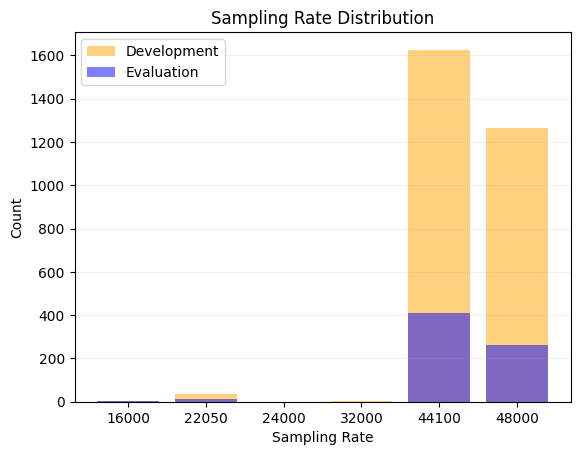

In [68]:
sampling_rate_dev = Counter(sampling_rates_dev)
sampling_rate_eval = Counter(sampling_rates_eval)

plt.figure()
# sort dictionary
sorted_key_dev = [int(el) for el in sampling_rate_dev.keys()]
sorted_key_dev.sort()
sorted_key_eval = [int(el) for el in sampling_rate_eval.keys()]
sorted_key_eval.sort()
plt.bar([str(el) for el in sorted_key_dev], [int(sampling_rate_dev[el]) for el in sorted_key_dev], label="Development", color="orange", alpha=0.5)
plt.bar([str(el) for el in sorted_key_eval], [int(sampling_rate_eval[el]) for el in sorted_key_eval], label="Evaluation", color="blue", alpha=0.5)
plt.title("Sampling Rate Distribution")
plt.xlabel("Sampling Rate")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.2, axis="y")

a = {el: sampling_rate_dev[el] for el in sorted_key_dev}
print(f"Development set: {a}")
a = {el: sampling_rate_eval[el] for el in sorted_key_eval}
print(f"Evaluation set: {a}")

Num words and num characters distribution

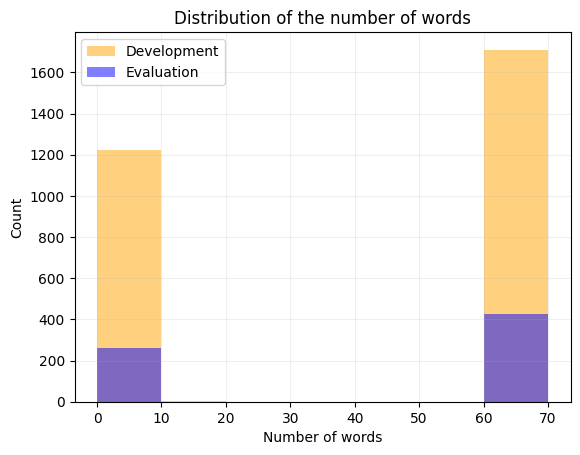

In [69]:
plt.figure()
plt.hist(df_dev["num_words"], bins=range(0,int((max(df_dev["num_words"])+10)),10), label="Development", color="orange", alpha=0.5)
plt.hist(df_eval["num_words"], bins=range(0,int((max(df_eval["num_words"])+10)),10), label="Evaluation", color="blue", alpha=0.5)
plt.xticks(range(0,int((max(df_dev["num_words"])+10)),10))
plt.title("Distribution of the number of words")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.2)

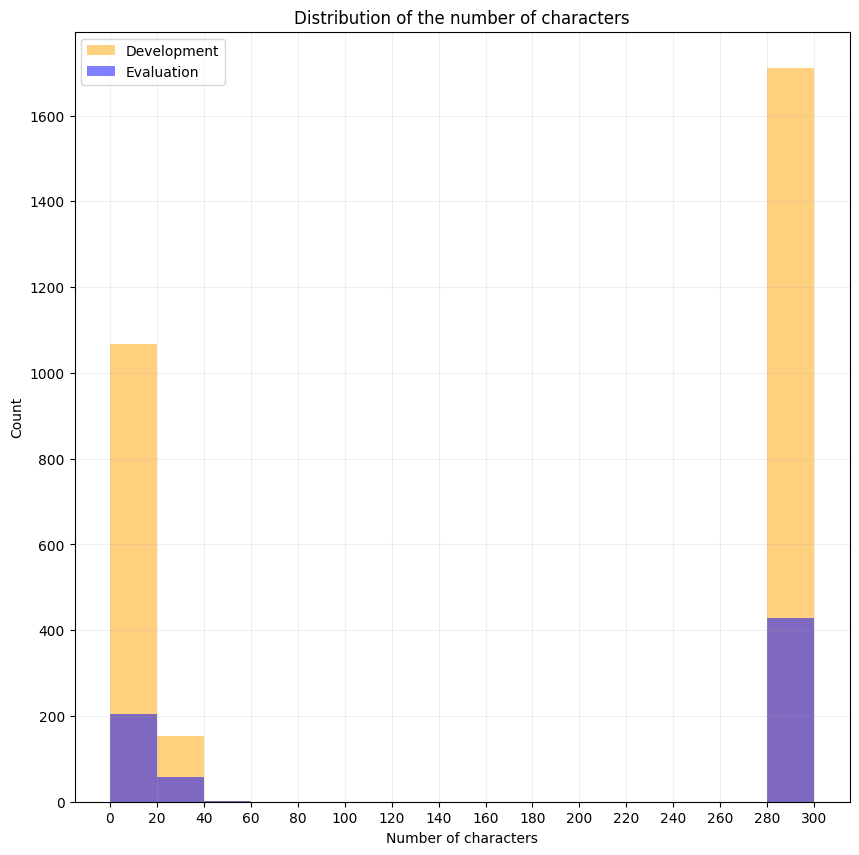

In [70]:
plt.figure(figsize=(10,10))
plt.hist(df_dev["num_characters"], bins=range(0,int((max(df_dev["num_characters"])+20)),20), label="Development", color="orange", alpha=0.5)
plt.hist(df_eval["num_characters"], bins=range(0,int((max(df_eval["num_characters"])+20)),20), label="Evaluation", color="blue", alpha=0.5)
plt.xticks(range(0,int((max(df_dev["num_characters"])+20)),20))
plt.title("Distribution of the number of characters")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.2)

In [71]:
df_dev['mean_silence'] = df_dev['silence_duration']/df_dev['num_pauses']
df_dev['silence_ratio'] = df_dev['silence_duration']/df_dev['duration']
df_dev['wps'] = df_dev['num_words']/df_dev['duration']

df_eval['mean_silence'] = df_eval['silence_duration']/df_eval['num_pauses']
df_eval['silence_ratio'] = df_eval['silence_duration']/df_eval['duration']
df_eval['wps'] = df_eval['num_words']/df_eval['duration']

In [72]:
df_dev['spectral_bandwidth'] = df_dev['spectral_bandwidth'].apply(lambda x: str(x[0]).replace('[', '').replace(']', '')).astype('float')
df_eval['spectral_bandwidth'] = df_eval['spectral_bandwidth'].apply(lambda x: str(x[0]).replace('[', '').replace(']', '')).astype('float')

df_dev['spectral_rolloff'] = df_dev['spectral_rolloff'].apply(lambda x: str(x[0]).replace('[', '').replace(']', '')).astype('float')
df_eval['spectral_rolloff'] = df_eval['spectral_rolloff'].apply(lambda x: str(x[0]).replace('[', '').replace(']', '')).astype('float')

In [73]:
df_dev.to_csv('data/development_processed.csv')
df_eval.to_csv('data/evaluation_processed.csv')